## Q1. Import the dataset and examine the variables. Use descriptive statistics and visualizations to understand the distribution and relationships between the variables.


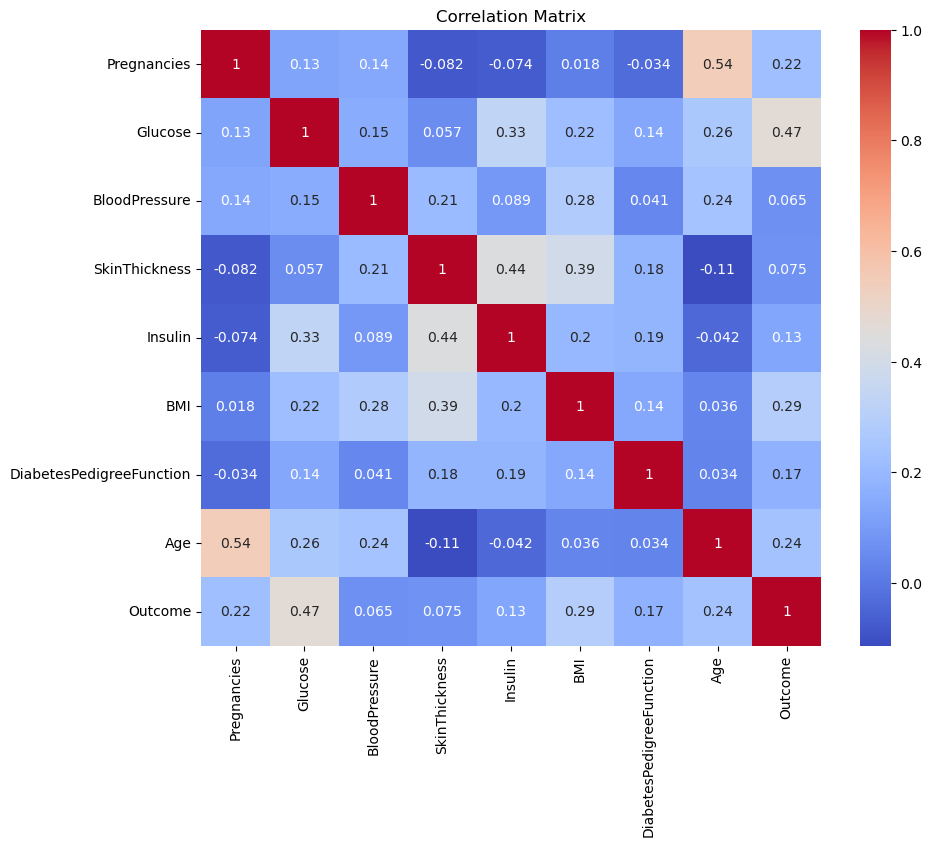

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = 'https://drive.google.com/uc?id=1Q4J8KS1wm4-_YTuc389enPh6O-eTNcx2'
diabetes_df = pd.read_csv(url)

diabetes_df.head()

diabetes_df.describe()

plt.figure(figsize=(10, 8))
sns.heatmap(diabetes_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

sns.pairplot(diabetes_df, hue='Outcome')
plt.show()

## Q2. Preprocess the data by cleaning missing values, removing outliers, and transforming categorical variables into dummy variables if necessary.


In [9]:
import numpy as np  
from scipy.stats import zscore

missing_values = diabetes_df.isnull().sum()
print(missing_values)

diabetes_df = diabetes_df.dropna()

z_scores = zscore(diabetes_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
diabetes_df = diabetes_df[filtered_entries]

print(diabetes_df.shape)


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
(688, 9)


## Q3. Split the dataset into a training set and a test set. Use a random seed to ensure reproducibility.


In [12]:
from sklearn.model_selection import train_test_split

X = diabetes_df.drop('Outcome', axis=1)
y = diabetes_df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (550, 8)
X_test shape: (138, 8)
y_train shape: (550,)
y_test shape: (138,)


## Q4. Use a decision tree algorithm, such as ID3 or C4.5, to train a decision tree model on the training set. Use cross-validation to optimize the hyperparameters and avoid overfitting.


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt_classifier = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_dt_classifier = grid_search.best_estimator_
best_dt_classifier.fit(X_train, y_train)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10,
                       random_state=42)

## Q5. Evaluate the performance of the decision tree model on the test set using metrics such as accuracy, precision, recall, and F1 score. Use confusion matrices and ROC curves to visualize the results.


Accuracy: 0.7028985507246377
Precision: 0.6363636363636364
Recall: 0.5283018867924528
F1 Score: 0.5773195876288659
Confusion Matrix:
[[69 16]
 [25 28]]


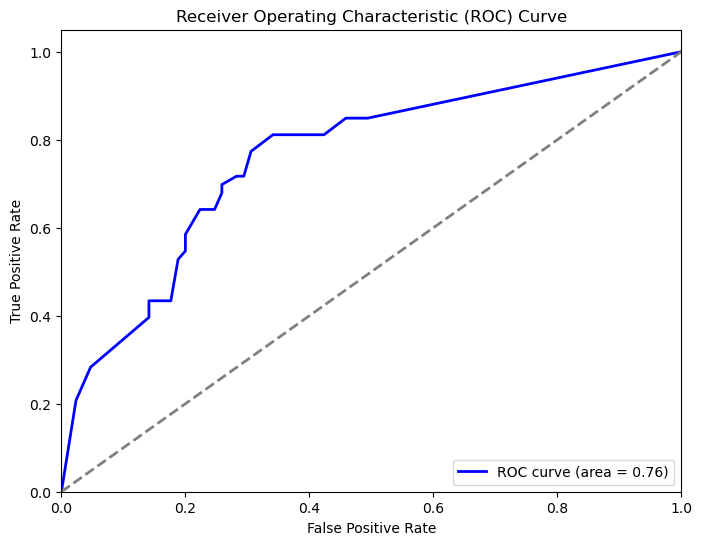

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

y_pred = best_dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

y_pred_prob = best_dt_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Q6. Interpret the decision tree by examining the splits, branches, and leaves. Identify the most important variables and their thresholds. Use domain knowledge and common sense to explain the patterns and trends.


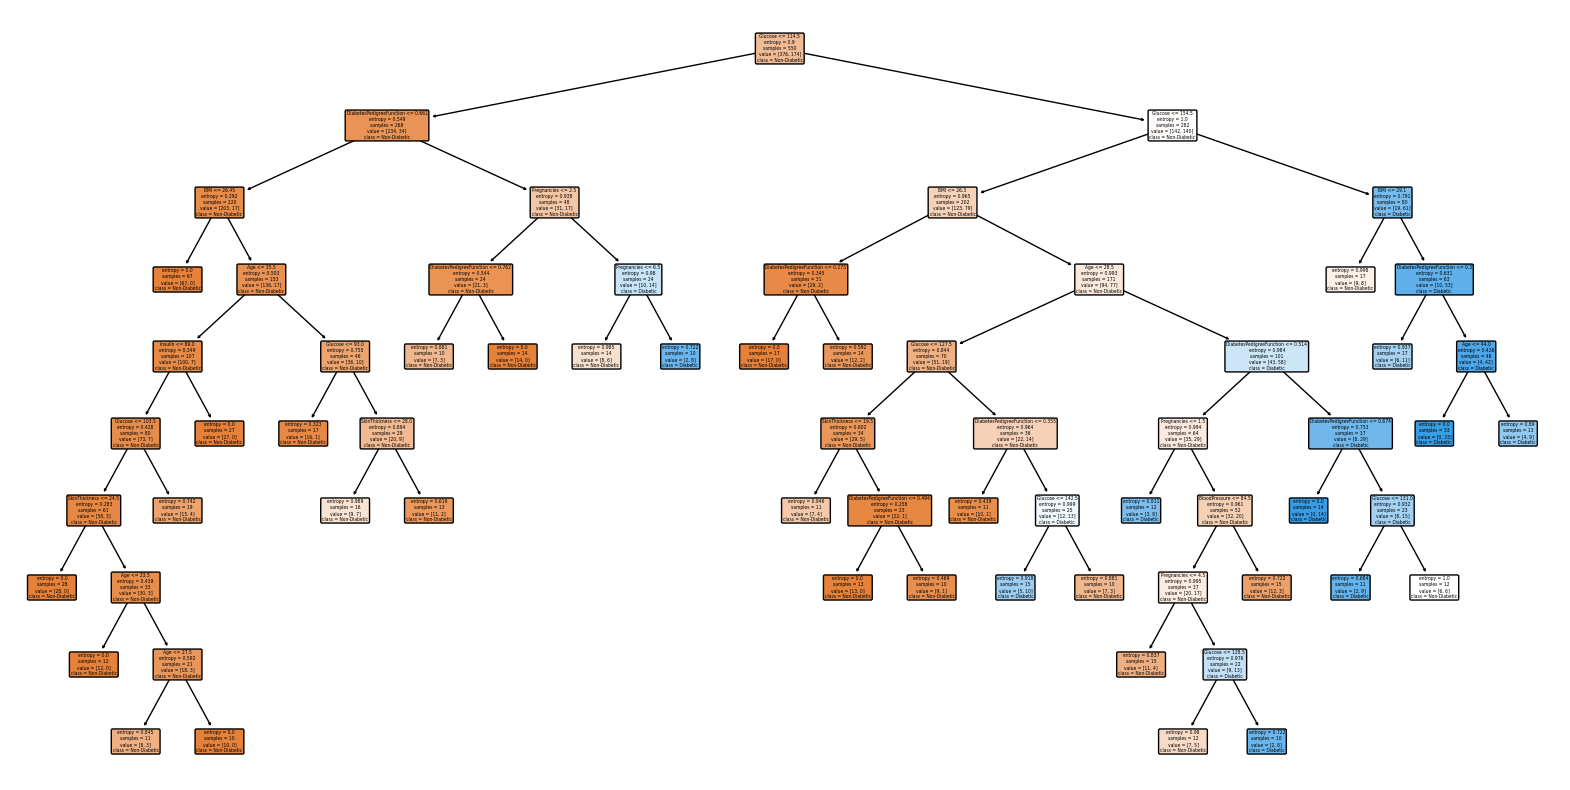

Feature Importances:
Glucose                     0.434242
DiabetesPedigreeFunction    0.191660
BMI                         0.123887
Age                         0.120172
Pregnancies                 0.071737
SkinThickness               0.036387
Insulin                     0.012428
BloodPressure               0.009485
dtype: float64


'\nThe decision tree splits the data based on the most important variables such as Glucose, BMI, and Age. \nEach node represents a decision based on a threshold value of a variable. For example, a split on Glucose at a certain value \ncan separate diabetic patients from non-diabetic patients. The tree uses the best splits to maximize information gain at each step.\n'

In [15]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(best_dt_classifier, feature_names=X.columns, class_names=['Non-Diabetic', 'Diabetic'], filled=True, rounded=True)
plt.show()

importances = best_dt_classifier.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances)

# Interpretation
"""
The decision tree splits the data based on the most important variables such as Glucose, BMI, and Age. 
Each node represents a decision based on a threshold value of a variable. For example, a split on Glucose at a certain value 
can separate diabetic patients from non-diabetic patients. The tree uses the best splits to maximize information gain at each step.
"""


## Q7. Validate the decision tree model by applying it to new data or testing its robustness to changes in the dataset or the environment. Use sensitivity analysis and scenario testing to explore the uncertainty and risks.


In [18]:
noise = np.random.normal(0, 0.1, X_test.shape)
X_test_noisy = X_test + noise

y_pred_noisy = best_dt_classifier.predict(X_test_noisy)

accuracy_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)

print(f"Accuracy with Noise: {accuracy_noisy}")
print(f"Precision with Noise: {precision_noisy}")
print(f"Recall with Noise: {recall_noisy}")
print(f"F1 Score with Noise: {f1_noisy}")

# Interpretation
"""
The sensitivity analysis shows how the model's performance changes when noise is added to the data.
If the performance metrics significantly drop, the model may be sensitive to changes in the input data,
indicating potential robustness issues. Scenario testing can help identify such weaknesses and improve the model's reliability.
"""


Accuracy with Noise: 0.7028985507246377
Precision with Noise: 0.6363636363636364
Recall with Noise: 0.5283018867924528
F1 Score with Noise: 0.5773195876288659


"\nThe sensitivity analysis shows how the model's performance changes when noise is added to the data.\nIf the performance metrics significantly drop, the model may be sensitive to changes in the input data,\nindicating potential robustness issues. Scenario testing can help identify such weaknesses and improve the model's reliability.\n"